### 数据处理
- 原始数据集直接从Kaggle上下载，解压后train目录下一共有25000张图片，test目录下一共有12500张图片
- 我们需要通过Keras ImageDataGenerator的flow_from_directory方法来加载我们的图片，所以我们需要将训练集和测试集的图片放到子文件夹中
- 测试集很简单，建一个子目录，将文件全部移动过去就行
- 训练集需要建立两个子目录，将狗和猫的图片分别移动到两个子目录中去
- 训练集中的图片名称格式为{种类}.序号.jpg，比如 cat.1.jpg 或 dog.1.jpg。我们可以利用命名规则来移动训练集的图片

当前的图片目录结构如下
```
data
 ├── test   [12500 images]
 └── train  [25000 images]
```
预处理后图片目录结构如下
```
data
 ├── test
 │   └── none [12500 images]
 └── train
     ├── cat  [12500 images]
     └── dog  [12500 images]
```

In [10]:
# 数据处理代码
import os
from shutil import move

train_src = 'data/train/'
test_src = 'data/test/'
dog_dest = 'data/train/dog/'
cat_dest = 'data/train/cat/'
test_dest = 'data/test/none/'

#创建子目录
os.makedirs(dog_dest, exist_ok=True)
os.makedirs(cat_dest, exist_ok=True)
os.makedirs(test_dest, exist_ok=True)

#移动测试图片至子文件夹中
for root, dirs, files in os.walk(test_src):
    if(root == test_src):
        for name in files:
            if(name.find('jpg')>-1):
                move(test_src + name, test_dest + name)

#移动训练集图片至对应的子文件夹中
for root, dirs, files in os.walk(train_src):
    if(root == train_src):
        for name in files:
            if(name.find('jpg')>-1 and name.find('cat')>-1):
                move(train_src + name, cat_dest + name)
            elif(name.find('jpg')>-1 and name.find('dog')>-1):
                move(train_src + name, dog_dest + name)
            else:
                pass

print("cat images: ", 
      len([name for name in os.listdir(cat_dest) if os.path.isfile(os.path.join(cat_dest, name))]))
print("dog images: ", 
      len([name for name in os.listdir(dog_dest) if os.path.isfile(os.path.join(dog_dest, name))]))
print("test images: ", 
      len([name for name in os.listdir(test_dest) if os.path.isfile(os.path.join(test_dest, name))]))

cat images:  12500
dog images:  12500
test images:  12500


### 导出深度特征
- 根据当前训练以及测试集导出VGG16,VGG19,ResNet50,Xception以及InceptionV3的深度特征
- VGG16,VGG19,ResNet50要求的图片的大小为（224， 224），Xception，Inception要求的图片大小为（299，299）
- 先对所有数据进行一个预处理的操作，把数据缩放到-1到1之间
- 其次我们加入一个平局池化操作，一方面是缩小我们导出的深度特征文件的大小，另一方是防止过拟合
- 最后使用Keras的ImageGenerator导出深度特征的数组，存放在本地磁盘上供接下来的模型训练使用
- 每个模型导出深度特征的耗时，如下
- VGG16 耗时约3分25秒
- VGG19 耗时约3分52秒
- ResNet50 耗时约3分30秒，
- InceptionV3 耗时约4分34秒
- Xception 耗时约6分钟56秒

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import time
import h5py
import math

train_data_path = 'data/train/'
test_data_path = 'data/test/'

def save_bottleneck_features(MODEL, image_size, module_name, preprocess):
    
    start_time = time.time()
    
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = Lambda(preprocess)(input_tensor)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(train_data_path, image_size, shuffle=False)
    test_generator = gen.flow_from_directory(test_data_path, image_size, shuffle=False, class_mode=None)

    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    
    with h5py.File("bottleneck_features/{}_bottleneck_features.h5".format(module_name)) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
        
    end_time = time.time()
    
    print("{} extract features total consumed: {} seconds".format(module_name, end_time - start_time))

c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
save_bottleneck_features(VGG16, (224, 224), 'VGG16', vgg16.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG16 extrac features total consumed: 205.36566758155823 seconds


In [2]:
save_bottleneck_features(VGG19, (224, 224), 'VGG19', vgg19.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG19 extrac features total consumed: 232.02474784851074 seconds


In [3]:
save_bottleneck_features(ResNet50, (224, 224), 'ResNet50', resnet50.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
ResNet50 extrac features total consumed: 210.49121832847595 seconds


In [4]:
save_bottleneck_features(InceptionV3, (299, 299), 'InceptionV3', inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
InceptionV3 extrac features total consumed: 274.9980471134186 seconds


In [5]:
save_bottleneck_features(Xception, (299, 299), 'Xception', xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Xception extrac features total consumed: 416.50056076049805 seconds


### 模型训练
- 这里一共定义了4个方法:
- retrieve_features用于读取本地磁盘的深度特征文件并从文件中提取出X_train,X_test,y_train3个数组
- train_model用于构建并训练自己的模型，我们的模型包含2层，BatchNormalization层是为了防止过拟合，Dense层为了做分类。
- generate_submission_csv用于生成提交至Kaggle的文件
- plot_model用于把模型的训练过程中的数据绘制成图表

In [84]:
import h5py
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from keras.optimizers import *
import time
import matplotlib.pyplot as plt
%matplotlib inline

def retrieve_features(files):
    X_train = []
    X_test = []
    y_train = []
    
    for filename in files:
        with h5py.File(filename, 'r') as h:
            X_train.append(np.array(h['train']))
            X_test.append(np.array(h['test']))
            y_train = np.array(h['label'])
        
    X_train = np.concatenate(X_train, axis=1)
    X_test = np.concatenate(X_test, axis=1)
    
    return X_train, X_test, y_train

    

def train_model(X_train, y_train, epochs, optimizer='adam', verbose=0):
    # construct model
    input_tensor = Input(X_train.shape[1:])
    x = BatchNormalization()(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)
    # compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # train model
    start_time = time.time()
    model.fit(X_train, y_train, batch_size=200, epochs=epochs, validation_split=0.2, verbose=verbose)
    end_time = time.time()
    print("Trainning model total consumed:{:.2f} seconds".format(end_time - start_time))
    
    return model

def generate_submission_csv(X_test, model, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test, verbose=0)
    end_time = time.time()
    print("Predicting model total consumed:{:.2f} seconds".format(end_time - start_time))
    y_pred = y_pred.clip(min=0.005, max=0.995)

    df = pd.read_csv("data/sample_submission.csv")

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory('data/test/', (224, 224), shuffle=False, batch_size=32, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
        df.at[index-1, 'label'] = y_pred[i]

    df.to_csv('data/{}_pred.csv'.format(model_name), index=None)

def plot_model(model):
    train_loss = model.history.history['loss']
    train_acc = model.history.history['acc']
    val_loss = model.history.history['val_loss']
    val_acc = model.history.history['val_acc']

    niter = np.arange(len(train_loss))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(niter, train_loss, label='train')
    ax1.plot(niter, val_loss, label='validation')
    ax1.set_title("loss")
    ax1.set_xlabel('ecphos')
    ax1.set_ylabel('loss')
    ax1.set_ylim(0, 0.35)

    ax2.plot(niter, train_acc, label='train')
    ax2.plot(niter, val_acc, label='validation')
    ax2.set_title("accuracy")
    ax2.set_xlabel('ecphos')
    ax2.set_ylabel('accuracy')
    ax2.set_ylim(0.85, 1)

    plt.legend()
    plt.show()
    
    print("train max acc:{:.4f}, validation max acc:{:.4f}, train min loss:{:.4f}, validation min loss:{:.4f}" \
          .format(np.max(train_acc), np.max(val_acc), np.min(train_loss), np.min(val_loss)))

### 迁移学习-VGG16
- 训练了200代，一共耗时175.38秒，训练集的最高准确率可以到达0.9897，验证集的最高准确率可以到达0.9744
- 预测一共耗时2.11秒，最后将生成的文件上传至Kaggle得分为0.07051

Trainning model total consumed:175.38 seconds


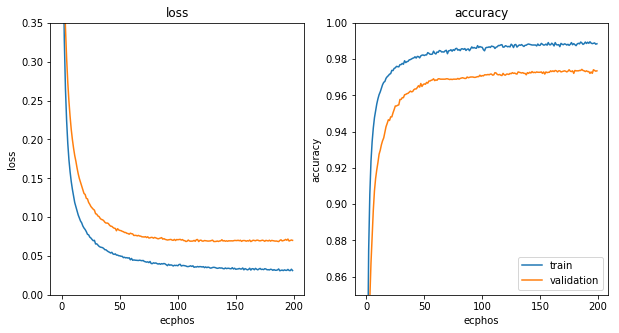

train max acc:0.9897, validation max acc:0.9744, train min loss:0.0310, validation min loss:0.0685
Predicting model total consumed:2.11 seconds
Found 12500 images belonging to 1 classes.


In [58]:
bottleneck_files = ["bottleneck_features/VGG16_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 200, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'VGG16')

###  迁移学习-VGG19
- 训练了200代，一共耗时171.04秒，训练集的最高准确率可以到达0.9908，验证集的最高准确率可以到达0.9754
- 预测一共耗时2.17秒，最后将生成的文件上传至Kaggle得分为0.06498

Trainning model total consumed:171.04 seconds


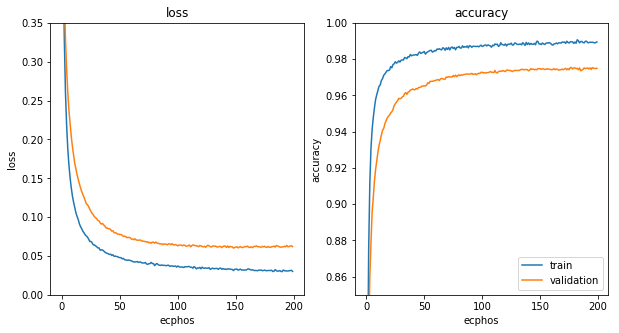

train max acc:0.9908, validation max acc:0.9754, train min loss:0.0298, validation min loss:0.0601
Predicting model total consumed:2.17 seconds
Found 12500 images belonging to 1 classes.


In [59]:
bottleneck_files = ["bottleneck_features/VGG19_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 200, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'VGG19')

###  迁移学习-ResNet50
- 训练了50代，训练一共耗时46.07秒，训练集的最高准确率可以到达0.9948，验证集的最高准确率可以到达0.9838
- 预测一共耗时0.83秒，最后将生成的文件上传至Kaggle得分为0.05707
- 这里只训练50代的原因是，发现50代以后容易出现过拟合的情况

Trainning model total consumed:46.07 seconds


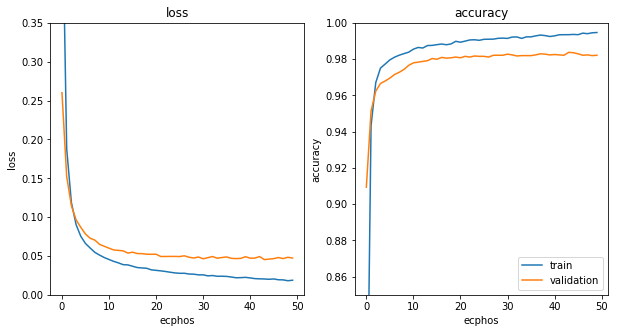

train max acc:0.9948, validation max acc:0.9838, train min loss:0.0181, validation min loss:0.0453
Predicting model total consumed:0.83 seconds
Found 12500 images belonging to 1 classes.


In [61]:
bottleneck_files = ["bottleneck_features/ResNet50_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 50, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'ResNet50')

###  迁移学习-InceptionV3
- 训练了20代，训练一共耗时20.74秒，训练集的最高准确率可以到达0.9932，验证集的最高准确率可以到达0.9930
- 预测一共耗时1.11秒，最后将生成的文件上传至Kaggle得分为0.04631

Trainning model total consumed:20.74 seconds


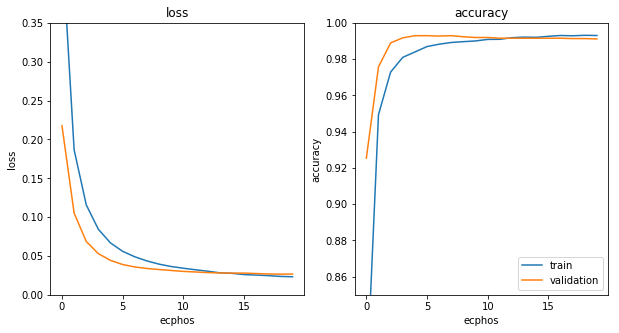

train max acc:0.9932, validation max acc:0.9930, train min loss:0.0232, validation min loss:0.0266
Predicting model total consumed:1.11 seconds
Found 12500 images belonging to 1 classes.


In [77]:
bottleneck_files = ["bottleneck_features/InceptionV3_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 20, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'InceptionV3')

###  迁移学习-Xception
- 训练了20代，训练一共耗时23.11秒，训练集的最高准确率可以到达0.9946，验证集的最高准确率可以到达0.9932
- 预测一共耗时1.17秒，最后将生成的文件上传至Kaggle得分为0.04390

Trainning model total consumed:23.11 seconds


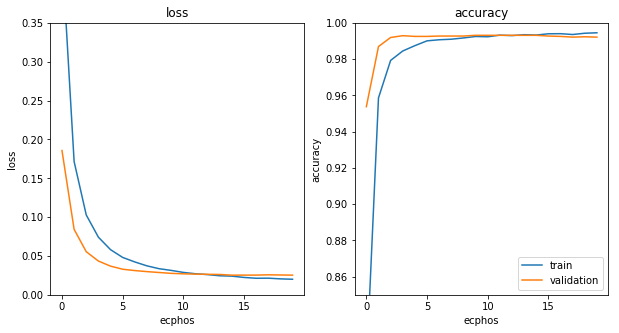

train max acc:0.9946, validation max acc:0.9932, train min loss:0.0200, validation min loss:0.0253
Predicting model total consumed:1.17 seconds
Found 12500 images belonging to 1 classes.


In [76]:
bottleneck_files = ["bottleneck_features/Xception_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = train_model(X_train, y_train, 20, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'Xception')

###  迁移学习-集成所有模型的属性
- 训练了50代，训练一共耗时67.65秒，训练集的最高准确率可以到达0.9954，验证集的最高准确率可以到达0.9940
- 预测一共耗时1.73秒，最后将生成的文件上传至Kaggle得分为0.04128

Trainning model total consumed:67.65 seconds


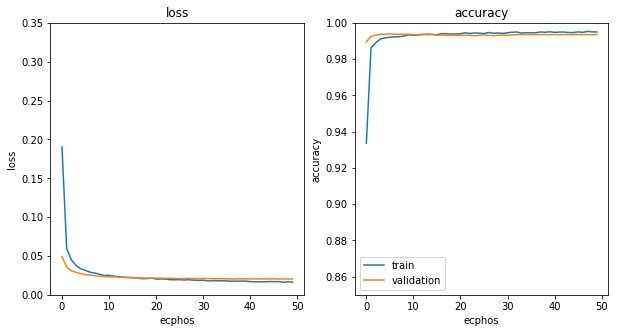

train max acc:0.9954, validation max acc:0.9940, train min loss:0.0162, validation min loss:0.0203
Predicting model total consumed:1.73 seconds
Found 12500 images belonging to 1 classes.


In [93]:
bottleneck_files = ["bottleneck_features/VGG16_bottleneck_features.h5",
                    "bottleneck_features/VGG19_bottleneck_features.h5", 
                    "bottleneck_features/ResNet50_bottleneck_features.h5",
                    "bottleneck_features/InceptionV3_bottleneck_features.h5",
                    "bottleneck_features/Xception_bottleneck_features.h5"]

X_train, X_test, y_train = retrieve_features(bottleneck_files)

optimizer = Adam(lr=0.00007, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

model = train_model(X_train, y_train, 50, optimizer)

plot_model(model)

generate_submission_csv(X_test, model, 'All_models')